<a href="https://colab.research.google.com/github/raissacamilla23/mythesis/blob/main/Try_to_Revised_Lyric_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting explicit lyrics with Deep Learning / PyTorc LSTM + Attention and BERT Classifier

This project is about the analysis of lyrics which having an explicit text, with using LSTM w/ Attention and BERT on PyTorch to predict if a lyric is about include explicit content or not. <br>


- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier w/ Attention
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary



In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Custom functions definition:

In [2]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [3]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=4e55b7ccb3611ce3fbd2f52f1c431e2bb00d3fc13e3dea8b4a31a0e696acd7d2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [4]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.6 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00


## Import libraries

In [7]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
#stop_words = set(stopwords.words('english'))
newStopWords = ["oh","see","yeah","ya","let","get","well","cause","could","i\'ll","i\'m","got","come","that"]
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(newStopWords)


# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-7-4d1cb729d124>:62: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Data Import

In [8]:
df = pd.read_csv("/content/drive/MyDrive/MYTESIS/songdata.csv")

In [9]:
df.head()

,artist,song,text,explicit_label
0,Chris Brown,D.G.I.F.U.,"[Verse 1: Tyga] Ya'll know me, the still sam...",explicit
1,Lil Wayne,High Beamin,[B.G.] Niggas be hating 'cause B.G. got it ...,explicit
2,Marilyn Manson,Unkillable Monster,How the fuck are we supposed to know When I'...,explicit
3,Ice Cube,It's A Man's World,Women they're good for nothing no maybe one th...,explicit
4,Ariana Grande,Thinking Bout You,[Verse 1] I've been thinking 'bout you Yea...,explicit


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5768 entries, 0 to 5767
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   artist          5768 non-null   object
 1   song            5768 non-null   object
 2   text            5768 non-null   object
 3   explicit_label  5768 non-null   object
dtypes: object(4)
memory usage: 180.4+ KB


First we rename the columns using shorter words for easier reference.

In [11]:
df = df.rename(columns={ 'text': 'lyric','explicit_label': 'labelname'})

### Are there duplicated lyrics?

In [12]:
df.duplicated().sum()

229

There are some duplicated lyrics, we will remove them.

In [13]:
df = df[~df.duplicated()]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5539 entries, 0 to 5767
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artist     5539 non-null   object
 1   song       5539 non-null   object
 2   lyric      5539 non-null   object
 3   labelname  5539 non-null   object
dtypes: object(4)
memory usage: 216.4+ KB


### Are the classes balanced?

In [16]:
df.labelname.value_counts()

non_explicit    2884
explicit        2655
Name: labelname, dtype: int64

# lyrics text deep cleaning

Next, we will define custom functions to clean the texts of the lyrics.

In [17]:
# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(lyric):
    lyric = re.sub(r'\r|\n', ' ', lyric.lower())  # Replace newline and carriage return with space, and convert to lowercase
    lyric = re.sub(r"(?:\@|https?\://)\S+", "", lyric)  # Remove links and mentions
    lyric = re.sub(r'[^\x00-\x7f]', '', lyric)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    lyric = lyric.translate(table)
    lyric = ' '.join(word for word in lyric.split() if word not in stop_words)
    return lyric


# Filter special characters such as & and $ present in some words
def filter_chars(lyric):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in lyric.split())

# Remove multiple spaces
def remove_mult_spaces(lyric):
    return re.sub(r"\s\s+", " ", lyric)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(lyric):
    try:
        lang = detect(lyric)
    except LangDetectException:
        lang = "unknown"
    return lyric if lang == "en" else ""

# Expand contractions
def expand_contractions(lyric):
    return contractions.fix(lyric)

# Remove numbers
def remove_numbers(lyric):
    return re.sub(r'\d+', '', lyric)

# Lemmatize words
def lemmatize(lyric):
    words = word_tokenize(lyric)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(lyric, min_len=2):
    words = lyric.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(lyric):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', lyric)

# Remove repeated punctuation
def remove_repeated_punctuation(lyric):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', lyric)

# Remove extra whitespace
def remove_extra_whitespace(lyric):
    return ' '.join(lyric.split())


# Remove spaces at the beginning and end of the lyric
def remove_spaces_lyric(lyric):
    return lyric.strip()

# Remove short lyrics
#def remove_short_lyrics(lyric, min_words=3):
 #   words = lyric.split()
  #  return lyric if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_lyric(lyric):

    lyric = expand_contractions(lyric)
    lyric = filter_non_english(lyric)
    lyric = strip_all_entities(lyric)

    lyric = filter_chars(lyric)
    lyric = remove_mult_spaces(lyric)
    lyric = remove_numbers(lyric)
    lyric = lemmatize(lyric)
    lyric = remove_short_words(lyric)
    lyric = replace_elongated_words(lyric)
    lyric = remove_repeated_punctuation(lyric)
    lyric = remove_extra_whitespace(lyric)
    lyric = remove_spaces_lyric(lyric)
    lyric = ' '.join(lyric.split())  # Remove multiple spaces between words
    return lyric

In [18]:
df['lyric_clean'] = [clean_lyric(lyric) for lyric in df['lyric']]

In [19]:
df.head()

,artist,song,lyric,labelname,lyric_clean
0,Chris Brown,D.G.I.F.U.,"[Verse 1: Tyga] Ya'll know me, the still sam...",explicit,verse tyga yall know still og young tyg hated ...
1,Lil Wayne,High Beamin,[B.G.] Niggas be hating 'cause B.G. got it ...,explicit,bg nigga hating bg top line ride hummer rover ...
2,Marilyn Manson,Unkillable Monster,How the fuck are we supposed to know When I'...,explicit,fuck supposed know monster way refuse die fuck...
3,Ice Cube,It's A Man's World,Women they're good for nothing no maybe one th...,explicit,woman good nothing maybe one thing serve need ...
4,Ariana Grande,Thinking Bout You,[Verse 1] I've been thinking 'bout you Yea...,explicit,verse thinking bout missing hell need still he...


### Are there duplicate lyrics after the cleaning?

In [20]:
print(f'There are around {int(df["lyric_clean"].duplicated().sum())} duplicated lyrics, we will remove them.')

There are around 67 duplicated lyrics, we will remove them.


In [21]:
df.drop_duplicates("lyric_clean", inplace=True)

In [23]:
df.labelname.value_counts()

non_explicit    2859
explicit        2613
Name: labelname, dtype: int64

In [24]:
labelname = ["explicit","non_explicit"]

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

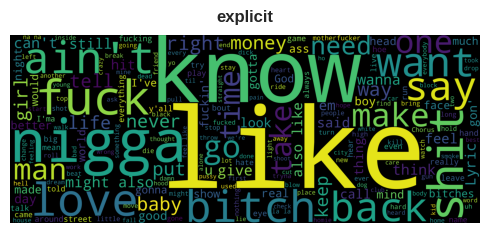

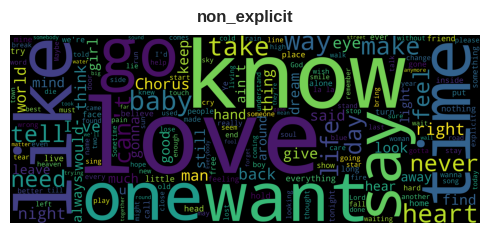

In [27]:
labels = df['labelname'].unique()
for labelname in labels:
    lyric = " ".join(df[df['labelname'] == labelname]['lyric'])
    wordcloud = WordCloud(width = 5000, height = 2000,
                    background_color ='black',
                    stopwords = stop_words,
                    min_font_size = 12).generate(lyric)
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(labelname)
    plt.show()

# lyrics length analysis

In [28]:
df['lyric_len'] = [len(lyric.split()) for lyric in df.lyric_clean]

In [29]:
df.sort_values(by=['lyric_len'], ascending=False)

,artist,song,lyric,labelname,lyric_clean,lyric_len
2060,Flatbush Zombies,Your Favorite Rap Song,Your Favorite Rap Song Lyrics Oh I swear All ...,explicit,favorite rap song lyric swear ever wanted some...,1227
2752,Kendrick Lamar,Mortal Man,Translations Español Italiano English Portuguê...,explicit,translation espaold italiano english portugus ...,1014
2586,Eminem,Campaign Speech,Campaign Speech Lyrics Jumped out of the 2nd f...,explicit,campaign speech lyric jumped nd floor record s...,786
2316,"JAY-Z', {'label': 'spotify:artist:0A7g2YbCA9F...",Reservoir Dogs,Reservoir Dogs Lyrics Fuck -- shit is real rig...,explicit,reservoir dog lyric fuck shit real right rocaf...,613
2266,Eminem,Untouchable,Translations English Türkçe Untouchable Lyrics...,explicit,translation english trke untouchable lyric han...,596
...,...,...,...,...,...,...
1844,Nate Dogg,Dedication,Dedication Lyrics This is dedicated to the nig...,explicit,dedication lyric dedicated nigga really day on...,16
1661,David Guetta,What the Fuck,What the Fuck Lyrics What the fuck What the fu...,explicit,fuck lyric fuck fuck fuck fuck fuck might also...,11
1060,The Neptunes,Intro,Intro Lyrics1 2 3 41 2 3 41 2 3 4 1C...,explicit,intro lyric clone might also like embed,7
2270,"50 Cent', {'label': 'spotify:artist:1UE4l8O8P...",Emotional,Emotional Lyrics I get emotional You might als...,explicit,emotional lyric emotional might also like embed,7


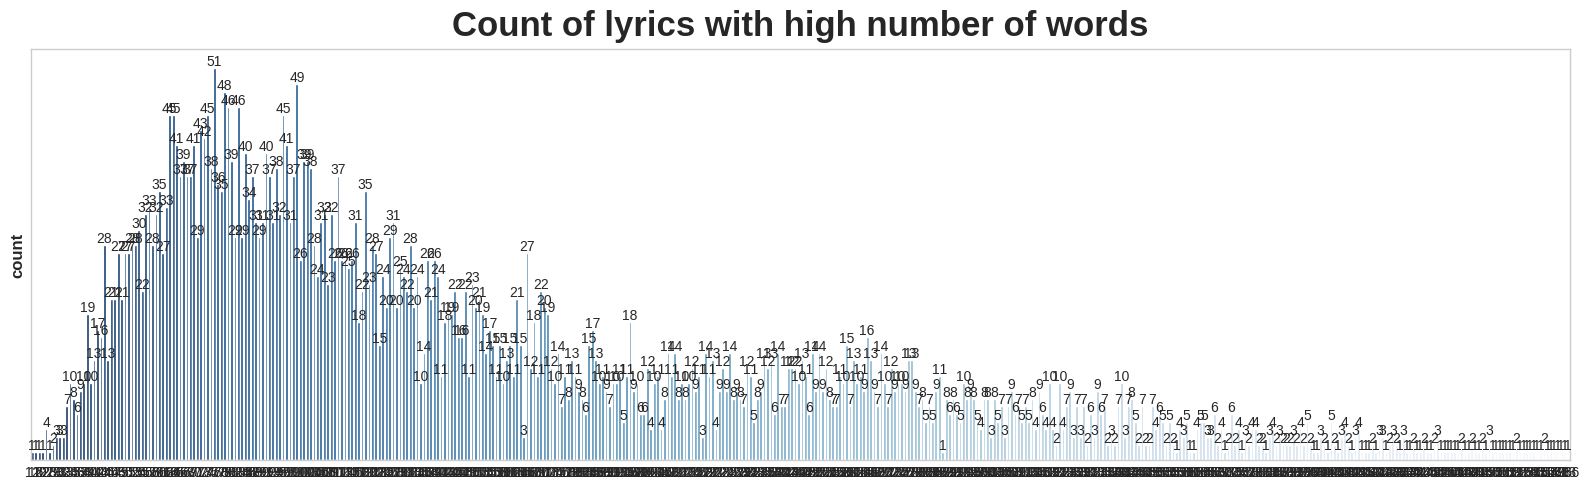

In [30]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='lyric_len', data=df[(df['lyric_len']<=1000) & (df['lyric_len']>10)], palette='Blues_r')
plt.title('Count of lyrics with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [31]:
df = df[df['lyric_len'] < df['lyric_len'].quantile(0.995)]

In [32]:
max_len = np.max(df['lyric_len'])
max_len

477

In [33]:
df.sort_values(by=["lyric_len"], ascending=False)

,artist,song,lyric,labelname,lyric_clean,lyric_len
1325,"Eminem', 'Nate Dogg",Till I Collapse,Translations Español Türkçe Português Italiano...,explicit,translation espaold trke portugus italianofran...,477
1677,Eminem,Marshall Mathers,Translations Italiano Русский Marshall Mathers...,explicit,translation italiano marshall mathers lyric kn...,474
2509,Polo G,Bloody Canvas,Bloody Canvas Lyrics Head's burnin' wasn't to...,explicit,bloody canvas lyric head burnin told leave wor...,474
1544,Kendrick Lamar,The Art of Peer Pressure,Translations English Português Türkçe Svenska ...,explicit,translation english portugus trke svenska espa...,473
446,Vybz Kartel,Gun Session,"Yeah, yeah testing one two three it's Akon the...",explicit,testing one two three akon illegal alien yea s...,471
...,...,...,...,...,...,...
1844,Nate Dogg,Dedication,Dedication Lyrics This is dedicated to the nig...,explicit,dedication lyric dedicated nigga really day on...,16
1661,David Guetta,What the Fuck,What the Fuck Lyrics What the fuck What the fu...,explicit,fuck lyric fuck fuck fuck fuck fuck might also...,11
1060,The Neptunes,Intro,Intro Lyrics1 2 3 41 2 3 41 2 3 4 1C...,explicit,intro lyric clone might also like embed,7
2270,"50 Cent', {'label': 'spotify:artist:1UE4l8O8P...",Emotional,Emotional Lyrics I get emotional You might als...,explicit,emotional lyric emotional might also like embed,7


## column encoding

The target column will be encoded by ordinal encoding

In [ ]:
df['labelname'] = df['labelname'].replace({'explicit':1,'non_explicit':0})

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [36]:
X = df['lyric_clean']
y = df['labelname']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [39]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1829],
       [   1, 1653]])

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [41]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['lyric_clean', 'labelname']);

In [42]:
X_train = train_os['lyric_clean'].values
y_train = train_os['labelname'].values

In [43]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1829],
       [   1, 1829]])

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

In [44]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

In [45]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Finally we can instantiate the Naive Bayes model.

In [46]:
nb_clf = MultinomialNB()

In [47]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [48]:
nb_pred = nb_clf.predict(X_test_tf)

In [50]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=['explicit', 'non_explicit']))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    explicit       0.88      0.85      0.86       572
non_explicit       0.84      0.87      0.85       517

    accuracy                           0.86      1089
   macro avg       0.86      0.86      0.86      1089
weighted avg       0.86      0.86      0.86      1089



ValueError: ignored

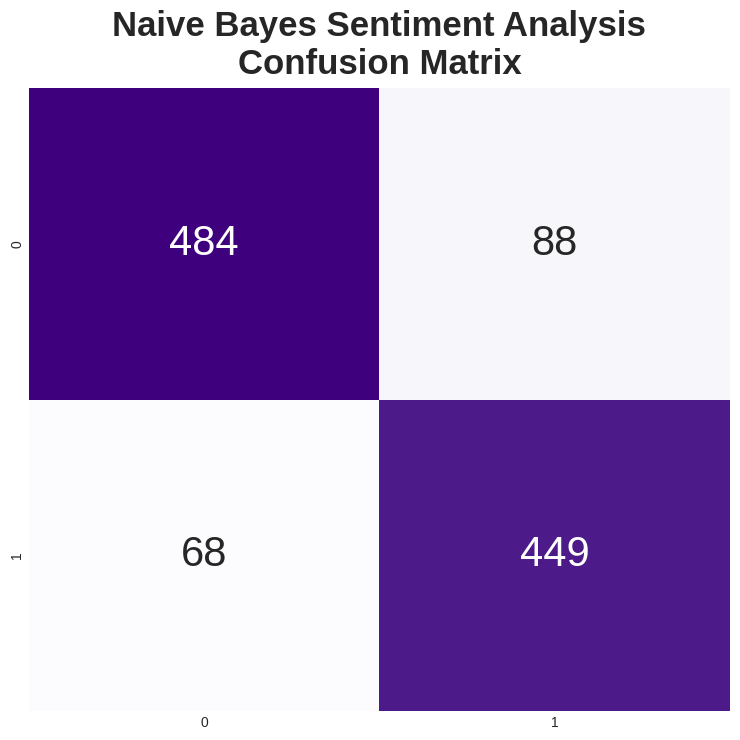

In [55]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix',labelname)

# PyTorch LSTM RNN w/ Attention

In this section, we will define a custom Unidirectional and Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the lyrics.

## Data preprocessing for LSTM

Similarly to what we did with Naive Bayes, we need to preprocess the data: in particular we will tokenize the sentences with a custom defined function. <br>
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [56]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for lyric in column for word in lyric.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    lyric_int = []
    for lyric in column:
        r = [vocab_to_int[word] for word in lyric.split()]
        lyric_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(lyric_int), seq_len), dtype = int)
    for i, review in enumerate(lyric_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [57]:
vocabulary, tokenized_column = Tokenize(df["lyric_clean"], max_len)

We can check how each lyric has been tokenized with an example:

In [58]:
df["lyric_clean"].iloc[0]

'verse tyga yall know still og young tyg hated nigga still keep shittin nigga lowkey fuck third degree keep dmv owe three schemin low tryna make nigga profitly money fuck sleep run mayor runnin shit barely maintainin bitch shit break neck busta shit shit til infinity predict bitch going chance outdone called enemy spit game talk shit grab gat call clique ball hard need assist best keep shit nigga knew gamell look bullshit drive shit hook tyga fucked yesterday freshest nigga america swear god lyin bruh lyin bruh america fucked nigga talkin bout shit pull like shit look whose talkin bitch look whose talkin bitch fucked shit shit shit loved one fucked shit shit trust nigga trust fund nigga verse chris brown nowadays everybody want talk like something say nothing come move lip extended clip make buddha shit shawty comin pullin hooter tip never use nigga abuse dick pussy air drop boat nigga right coast european caribbean sweatin hair dye fucked handful match fuckin bad bitch nigga savage be

This sentence is transformed to the vector:

In [59]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text lyrics and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [61]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [62]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

In [63]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [64]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 38681


In [65]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [66]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (38681, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [67]:
X = tokenized_column
y = df['labelname'].values

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [70]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1829],
       [   1, 1653]])

And then apply random oversampling on the training set.

In [71]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [72]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1829],
       [   1, 1829]])

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [73]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [74]:
BATCH_SIZE = 32

In [75]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling with Attention Layer

In this chapter we implement two Python classes: Attention and LSTM_Sentiment_Classifier.

The Attention class defines our attention mechanism. This technique is commonly used in Natural Language Processing tasks to allow our model to focus on specific parts of the input sequence when generating output. It learns to assign weights to different parts of the input data, indicating their relevance. This class initializes an attention layer which takes into account whether our LSTM network is bidirectional or not.

In the Attention class forward method, we first calculate the attention weights. These weights are computed by applying a tanh activation function to the concatenated hidden states and encoder outputs. A softmax is then applied to the attention weights, ensuring they sum to 1 and hence can be interpreted as probabilities.

Next, we define our LSTM_Sentiment_Classifier class, which uses the Attention mechanism to make predictions. This class includes an LSTM network which takes embedded word representations as input and outputs hidden states. It also includes an attention layer, which uses these hidden states to compute attention weights and apply them to the encoder outputs to get a context vector. This context vector is passed through a fully connected layer followed by a log-softmax function to produce the final output probabilities.

In the forward method of LSTM_Sentiment_Classifier, we pass our inputs through an embedding layer, followed by the LSTM network. We then calculate the attention weights and form a context vector. This context vector serves as a summary of the entire input sequence, weighted by the attention mechanism's output. We pass this context vector through a fully connected layer and a log-softmax function to make our final prediction.

Lastly, we define a method init_hidden to initialize the hidden state of our LSTM network. Depending on whether our LSTM network is bidirectional or not, we may need to double the size of our hidden state.

This LSTM model with attention allows us to better handle the complexities of language understanding by giving more importance to the relevant parts of our text data. This enhances the model's ability to understand context and thereby, improves the performance of our Sentiment Analysis task.

In [76]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        #hidden

In [77]:
NUM_CLASSES = 2
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(38681, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


# LSTM Training loop

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [78]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 82.291667).  Saving model ...
	Train_loss : 0.5573 Val_loss : 0.4285
	Train_acc : 71.902% Val_acc : 82.292%
Epoch 2:Validation accuracy increased (82.291667 --> 86.689815).  Saving model ...
	Train_loss : 0.4341 Val_loss : 0.3385
	Train_acc : 81.195% Val_acc : 86.690%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.6826 Val_loss : 0.5417
	Train_acc : 67.325% Val_acc : 71.296%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.4671 Val_loss : 0.7265
	Train_acc : 77.248% Val_acc : 52.662%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.5861 Val_loss : 0.4789
	Train_acc : 75.493% Val_acc : 82.176%
Epoch 6:Validation accuracy increased (86.689815 --> 90.162037).  Saving model ...
	Train_loss : 0.3413 Val_loss : 0.2796
	Train_acc : 87.802% Val_acc : 90.162%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.2001 Val_loss : 0.2440
	Train_acc : 93.448% Val_acc : 89.699%
Epoch 8:Validation accurac

In [79]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [80]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [82]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=['explicit', 'non_explicit']))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    explicit       0.91      0.92      0.92       572
non_explicit       0.91      0.90      0.91       516

    accuracy                           0.91      1088
   macro avg       0.91      0.91      0.91      1088
weighted avg       0.91      0.91      0.91      1088



ValueError: ignored

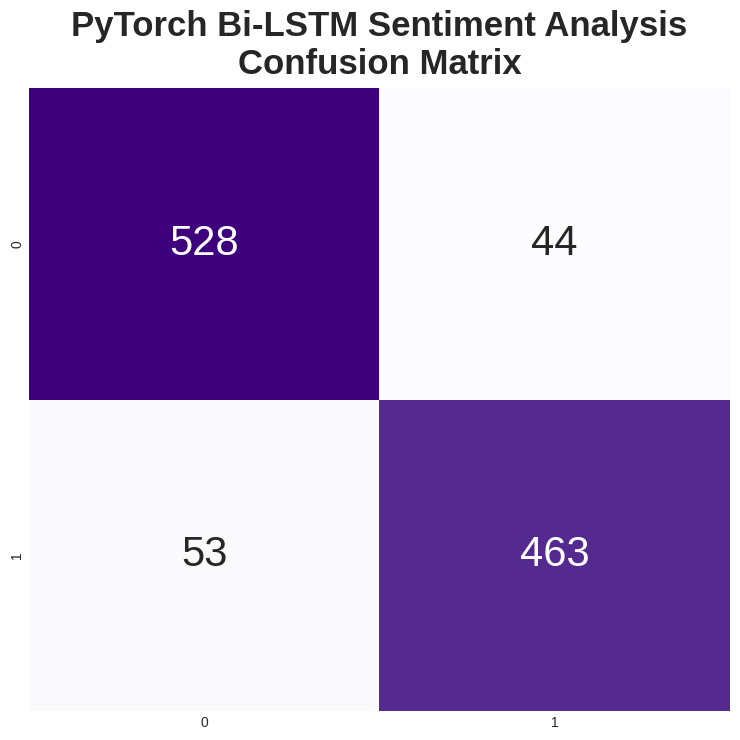

In [83]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', labelname)

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [84]:
X = df['lyric_clean'].values
y = df['labelname'].values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [87]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [88]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [89]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1829],
       [   1, 1829]])

# BERT Tokenization

Since we need to tokenize the lyrics (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [90]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

In [91]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train lyrics using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [92]:
# Tokenize train lyrics
encoded_lyrics = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized lyric
max_len = max([len(sent) for sent in encoded_lyrics])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


Max length:  725


In [93]:
MAX_LEN = 128

Then we can tokenize the train, validation and test lyrics using the custom define tokenizer.

In [94]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [95]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [96]:
batch_size = 32

In [97]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [98]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [99]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [101]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [102]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###

        # Put the model into the evaluation mode
        model.eval()

        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")

    print("Training complete!")

In [103]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.269094   |  4262.92 
   114    |   0.186577   |  560.82  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.259048    |  0.158341  |       95.47       |  5201.37 
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.145227   |  4278.96 
   114    |   0.138193   |  562.51  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.144371    |  0.151541  |       95.03

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [104]:
def bert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [105]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [106]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=['explicit', 'non_explicit']))

Classification Report for BERT :
               precision    recall  f1-score   support

    explicit       0.94      0.93      0.94       572
non_explicit       0.93      0.94      0.93       517

    accuracy                           0.93      1089
   macro avg       0.93      0.93      0.93      1089
weighted avg       0.93      0.93      0.93      1089



ValueError: ignored

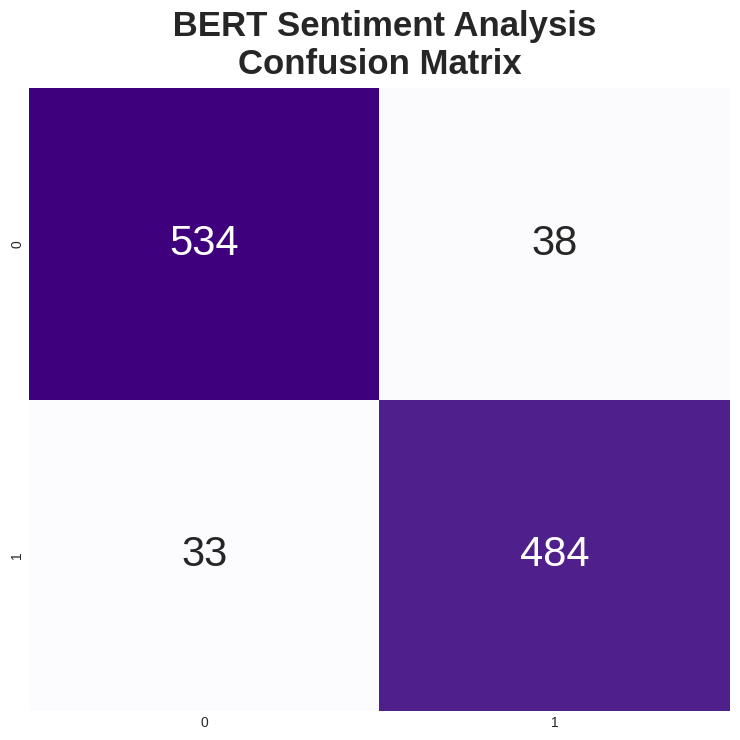

In [107]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', labelname)